In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import nnde
from mpl_toolkits.mplot3d import Axes3D
np.seterr(all='raise')
import pixiedust

Pixiedust database opened successfully


In [2]:
n_samples = 10
X_p = np.linspace(0, 1, n_samples)
Y_p = np.linspace(0, 1, n_samples)
X_p, Y_p = np.meshgrid(X_p, Y_p)
X_p = X_p.flatten()
Y_p = Y_p.flatten()
samples = np.array([X_p, Y_p]).T

## Example C

$$\frac{\partial^4\Psi}{\partial x^2 \partial y^2}(x, y) - \frac{\partial^3\Psi}{\partial x^2 \partial y}(x, y)=-{\pi^2 \over 4}\sin({\pi \over 2}x)(4-4y+\exp(-y^2)(4y^2+2y-2))$$

The analytic solution is: $\Psi(x,y)=\sin({\pi \over 2}x)(2y^2+\exp(-y^2))$.

With boundary conditions $\Psi(0,y)=0$, $\Psi(1, y)=\exp(-y^2)+2y^2$, $\Psi(x, 0)=\sin({\pi \over 2}x)$, and $\Psi(x, 1)=\sin({\pi \over 2}x)(\exp(-1)+2)$.

The trial solution for this case is $\Psi(x, y)=A(x, y) + B(x, y)N(x, y)$ with $B(x)=x(1-x)y(1-y)$ and $$A(x, y)= x(2y^2+\exp(-y^2)-1) + \sin({\pi \over 2}x) +y(\sin({\pi \over 2}x)-x)(1+\exp(-1)).$$

In [3]:
def exampleC_boundary_value(point):
  x = point[0]
  y = point[1]
  return (x*(2*y**2+np.exp(-y**2)-1)+np.sin(0.5*np.pi*x)+y*(np.sin(0.5*np.pi*x)-x)*(1+np.exp(-1)))

In [4]:
def exampleC_boundary_vanishing(point):
  x = point[0]
  y = point[1]
  return x * (1 - x) * y * (1 - y)

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_{i,j} \left(\frac{\partial^4\Psi}{\partial x^2 \partial y^2}(x, y) - \frac{\partial^3\Psi}{\partial x^2 \partial y}(x, y)+{\pi^2 \over 4}\sin({\pi \over 2}x)(4-4y+\exp(-y^2)(4y^2+2y-2))\right)^2$$
And the Laplace operator term acting on the trial solution becomes:
$$(\frac{\partial^4}{\partial x^2 \partial y^2} - \frac{\partial^3}{\partial x^2 \partial y})A(x, y)= {\pi^2 \over 4}\sin({\pi \over 2}x)(1+\exp(-1)$$
$$(\frac{\partial^4}{\partial x^2 \partial y^2} - \frac{\partial^3}{\partial x^2 \partial y})\left(x(1-x)y(1-y)N(x, y)\right)=$$
$$=2(3-2y)N(x,y)-2(1-2x)(3-2y)\frac{\partial N}{\partial x}(x,y)-x(1-x)(3-2y)\frac{\partial^2 N}{\partial x^2}(x,y) -2(2-5y+y^2)\frac{\partial N}{\partial y}(x,y) -2y(1-y)\frac{\partial^2 N}{\partial y^2}(x,y) +2(1-2x)(2-5y+y^2)\frac{\partial^2 N}{\partial x \partial y}(x,y) +x(1-x)(2-5y+y^2)\frac{\partial^3 N}{\partial x^2\partial y}(x,y) +2(1-2x)y(1-y)\frac{\partial^3 N}{\partial x\partial y^2}(x,y) +x(1-x)y(1-y)\frac{\partial^4 N}{\partial x^2\partial y^2}(x,y)$$

In [5]:
def exampleC_loss_function_single_point(self, point, non_squared=False, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  y = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  d2N = self.forward_pass(point, 2)
  
  dxdyN = self.forward_pass_arbitrary_derivative(point, np.array([1, 1]))
  dxdy2N = self.forward_pass_arbitrary_derivative(point, np.array([1, 2]))
  dx2dyN = self.forward_pass_arbitrary_derivative(point, np.array([2, 1]))
  dx2dy2N = self.forward_pass_arbitrary_derivative(point, np.array([2, 2]))
  
  loss = ( 0.25 * np.pi**2 * np.sin(np.pi*0.5*x)*(1+np.exp(-1)) +2*(3-2*y)*N - 2*(1-2*x)*(3-2*y)*dN[0, 0]
          - x*(1-x)*(3-2*y)*d2N[0, 0] -2*(2-5*y+y**2)*dN[0, 1] - 2*y*(1-y)*d2N[0, 1]
          + 2*(1-2*x)*(2-5*y+y**2)*dxdyN + x*(1-x)*(2-5*y+y**2)*dx2dyN + 2*(1-2*x)*y*(1-y)*dxdy2N
          +x*(1-x)*y*(1-y)*dx2dy2N
    )
  if non_squared:
    return loss[0][0]
  else:
    loss = loss ** 2
    return loss[0][0]

In [6]:
def exampleC_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [7]:
def exampleC_bias_change(self, point, label, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  y = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  
  db_N = self.network_derivative_bias(point, 0)
  db_dN = self.network_derivative_bias(point, 1)
  db_d2N = self.network_derivative_bias(point, 2)
  
  db_dxdyN = self.arbitrary_network_derivative_bias(point, np.array([1, 1]))
  db_dxdy2N = self.arbitrary_network_derivative_bias(point, np.array([1, 2]))
  db_dx2dyN = self.arbitrary_network_derivative_bias(point, np.array([2, 1]))
  db_dx2dy2N = self.arbitrary_network_derivative_bias(point, np.array([2, 2]))
  
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * ( 2*(3-2*y)*db_N[0, 0, m] - 2*(1-2*x)*(3-2*y)*db_dN[0, 0, m]
#           - x*(1-x)*(3-2*y)*db_d2N[0, 0, m] -2*(2-5*y+y**2)*db_dN[0, 1, m] - 2*y*(1-y)*db_d2N[0, 1, m]
#           + 2*(1-2*x)*(2-5*y+y**2)*db_dxdyN[0, m] + x*(1-x)*(2-5*y+y**2)*db_dx2dyN[0, m]
#           + 2*(1-2*x)*y*(1-y)*db_dxdy2N[0, m] +x*(1-x)*y*(1-y)*db_dx2dy2N[0, m]
      )
  return db

In [8]:
def exampleC_hidden_weights_change(self, point, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  y = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_dN = self.network_derivative_hidden_weights(point, 1)
  dH_d2N = self.network_derivative_hidden_weights(point, 2)
  
  dH_dxdyN = self.arbitrary_network_derivative_hidden_weights(point, np.array([1, 1]))
  dH_dxdy2N = self.arbitrary_network_derivative_hidden_weights(point, np.array([1, 2]))
  dH_dx2dyN = self.arbitrary_network_derivative_hidden_weights(point, np.array([2, 1]))
  dH_dx2dy2N = self.arbitrary_network_derivative_hidden_weights(point, np.array([2, 2]))

  
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * (2*(3-2*y)*dH_N[0, 0, m, p] - 2*(1-2*x)*(3-2*y)*dH_dN[0, 0, m, p]
          - x*(1-x)*(3-2*y)*dH_d2N[0, 0, m, p] -2*(2-5*y+y**2)*dH_dN[0, 1, m, p] - 2*y*(1-y)*dH_d2N[0, 1, m, p]
          + 2*(1-2*x)*(2-5*y+y**2)*dH_dxdyN[0, m, p] + x*(1-x)*(2-5*y+y**2)*dH_dx2dyN[0, m, p]
          + 2*(1-2*x)*y*(1-y)*dH_dxdy2N[0, m, p] +x*(1-x)*y*(1-y)*dH_dx2dy2N[0, m, p]
      )
  return dH

In [9]:
def exampleC_visible_weights_change(self, point, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  y = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_dN = self.network_derivative_visible_weights(point, 1)
  dV_d2N = self.network_derivative_visible_weights(point, 2)
  
  dV_dxdyN = self.arbitrary_network_derivative_visible_weights(point, np.array([1, 1]))
  dV_dxdy2N = self.arbitrary_network_derivative_visible_weights(point, np.array([1, 2]))
  dV_dx2dyN = self.arbitrary_network_derivative_visible_weights(point, np.array([2, 1]))
  dV_dx2dy2N = self.arbitrary_network_derivative_visible_weights(point, np.array([2, 2]))
  
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (2*(3-2*y)*dV_N[0, 0, m, p] - 2*(1-2*x)*(3-2*y)*dV_dN[0, 0, m, p]
          - x*(1-x)*(3-2*y)*dV_d2N[0, 0, m, p] -2*(2-5*y+y**2)*dV_dN[0, 1, m, p] - 2*y*(1-y)*dV_d2N[0, 1, m, p]
          + 2*(1-2*x)*(2-5*y+y**2)*dV_dxdyN[0, m, p] + x*(1-x)*(2-5*y+y**2)*dV_dx2dyN[0, m, p]
          + 2*(1-2*x)*y*(1-y)*dV_dxdy2N[0, m, p] + x*(1-x)*y*(1-y)*dV_dx2dy2N[0, m, p]
      )
  return dV

### Defining the trial solution with an apropiate network

In [12]:
exampleC_trial_solution = nnde.TrialSolution(loss_function=exampleC_loss_function,
                                        loss_function_single_point=exampleC_loss_function_single_point,
                                        bias_change=exampleC_bias_change,
                                        hidden_weights_change=exampleC_hidden_weights_change,
                                        visible_weights_change=exampleC_visible_weights_change,
                                        boundary_condition_value_function=exampleC_boundary_value,
                                        boundary_vanishing_function=exampleC_boundary_vanishing,
                                        input_dim=2, hidden_dim=10, output_dim=1, learning_rate=0.01, momentum=0)

### Training for 5000 epochs

In [13]:
# %%pixie_debugger
exampleC_trial_solution.train(samples, 100)

Epoch: 1 Loss function: 0.32826053757576623
Epoch: 2 Loss function: 0.17863578840011443
Epoch: 3 Loss function: 0.2854912722848449
Epoch: 4 Loss function: 1.2910287389569397
Epoch: 5 Loss function: 0.7951387133063463
Epoch: 6 Loss function: 0.19669630217111195
Epoch: 7 Loss function: 0.17245652299521055
Epoch: 8 Loss function: 0.1350186592410132
Epoch: 9 Loss function: 0.10213893305235257
Epoch: 10 Loss function: 0.24965461960870666
Epoch: 11 Loss function: 0.19398126208011576
Epoch: 12 Loss function: 0.19033389094647807
Epoch: 13 Loss function: 0.1431370393423192
Epoch: 14 Loss function: 0.1539235495006494
Epoch: 15 Loss function: 0.12974975944258235
Epoch: 16 Loss function: 0.11140626567667618
Epoch: 17 Loss function: 0.15017827277100443
Epoch: 18 Loss function: 0.1274679778987211
Epoch: 19 Loss function: 0.14639864172087477
Epoch: 20 Loss function: 0.12896077723505112
Epoch: 21 Loss function: 0.12662011512481686
Epoch: 22 Loss function: 0.11659629804473082
Epoch: 23 Loss function: 0

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

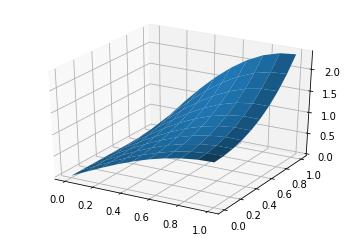

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
new_shape = int(np.sqrt(samples.shape[0]))
ZeCsol = np.array([exampleC_trial_solution.predict(samples[i]) for i in range(samples.shape[0])]).reshape((samples.shape[0],))
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=ZeCsol.reshape((new_shape, new_shape)), label='Numerical - Training')
# ax.scatter3D(xs=samples[:,0], ys=samples[:,1], zs=ZeCsol, label='Numerical - Training')
# plt.legend()
plt.show()

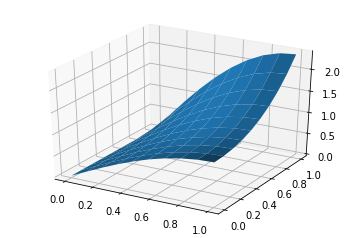

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ZeCanal = (2*samples[:,1]**2+np.exp(-samples[:,1]**2)) * np.sin(samples[:, 0]*np.pi*0.5)
ZeCdiff = ZeCsol - ZeCanal
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=ZeCanal.reshape((new_shape, new_shape)), label='Analytic')
# plt.legend()
plt.show()

In [16]:
ZeCdiff.max()

0.050261568694566779157